# <center> Практика. Статистические тесты в контексте EDA

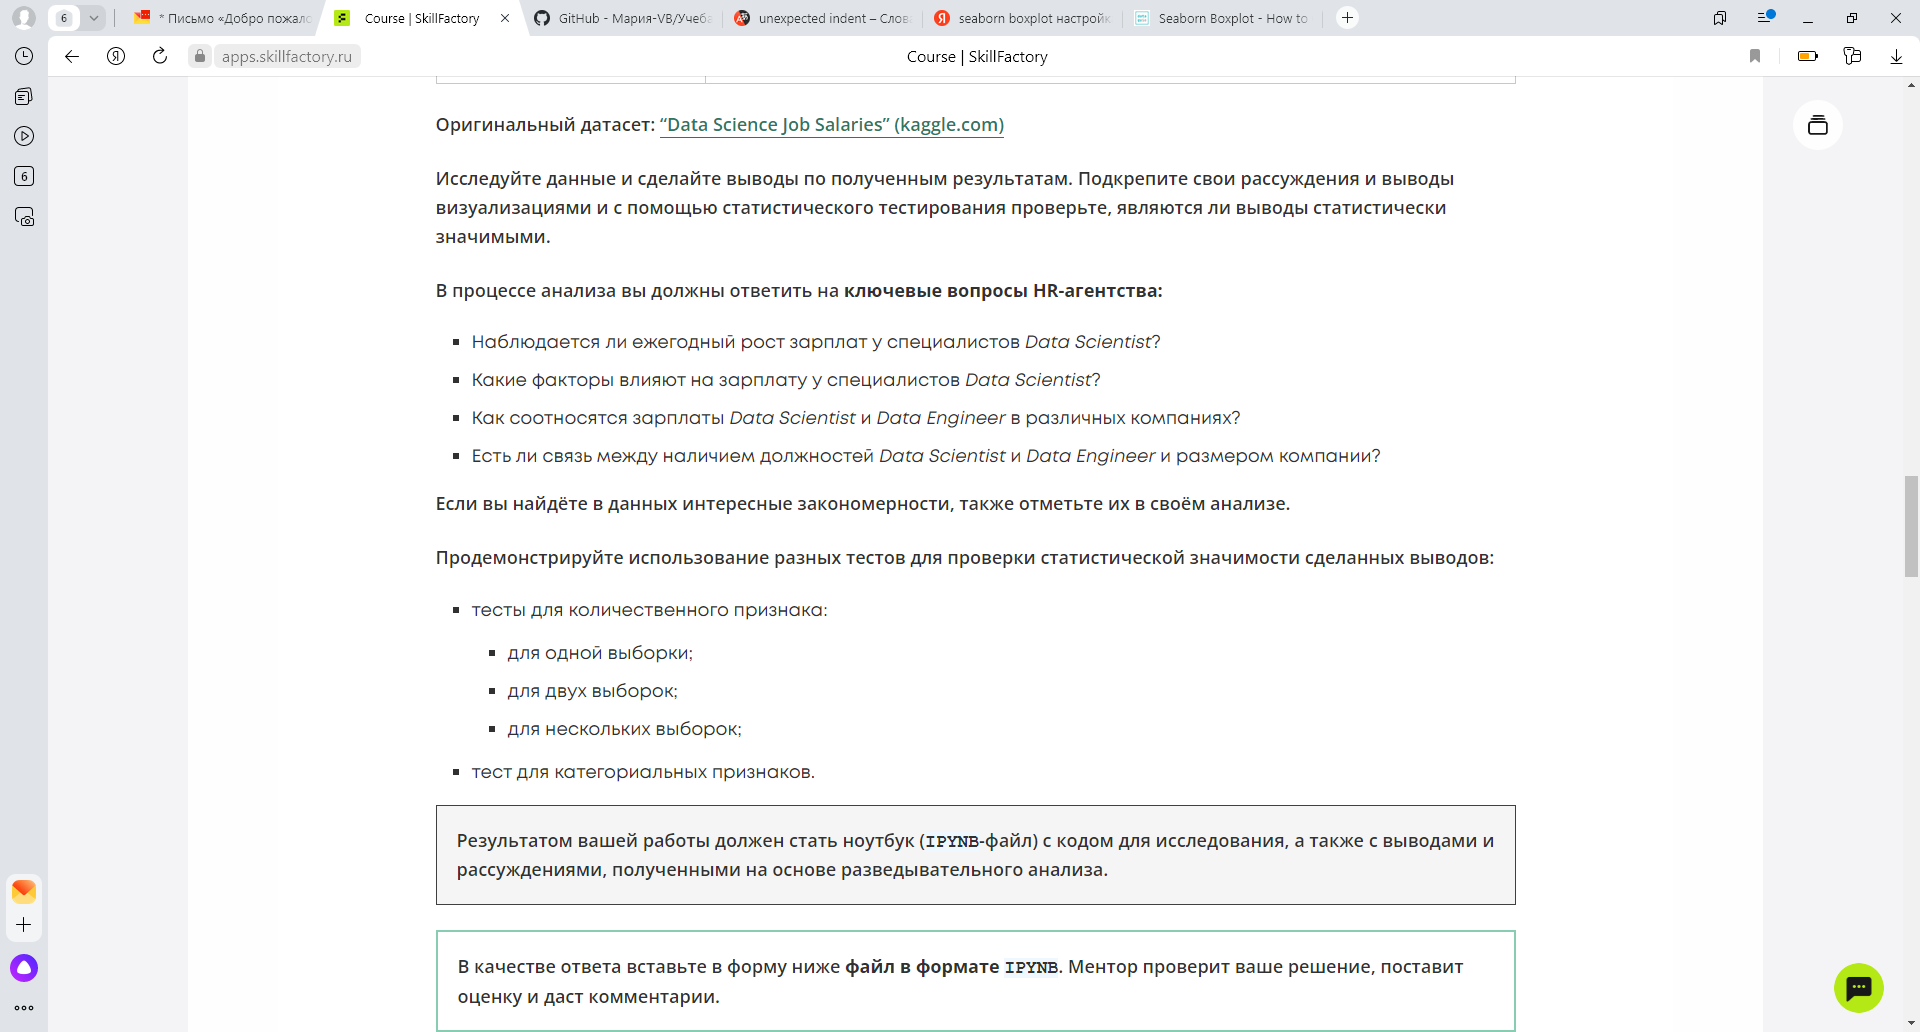

## Постановка задачи

HR-агентство изучает тренды на рынке труда в IT. Компания хочет провести исследование на основе данных о зарплатах в сфере Data Science за 2020–2022 годы и получить некоторые выводы.

Ключевые вопросы HR-агентства:

Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?
Какие факторы влияют на зарплату у специалистов Data Scientist?
Как соотносятся зарплаты Data Scientist и Data Engineer в различных компаниях?
Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?


## Загрузка данных

In [74]:
# загружаем необходимые библиотеки
import pandas as pd
import numpy as np

from scipy import stats
import statsmodels.api as sm
from statsmodels import stats as sms

import matplotlib.pyplot as plt
import seaborn as sns

# делаем визуальную настройку графиков
sns.set_theme("notebook") 
sns.set_palette("Set2") 

In [75]:
# загружаем датасет
data = pd.read_csv('ds_salaries.csv')
data.head()

,Unnamed: 0,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L


In [76]:
# задаём уровень значимости
alpha = 0.05 
print("Уровень значимости alpha = {:.2f}".format(alpha))

Уровень значимости alpha = 0.05


## Описательный анализ данных

In [77]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          607 non-null    int64 
 1   work_year           607 non-null    int64 
 2   experience_level    607 non-null    object
 3   employment_type     607 non-null    object
 4   job_title           607 non-null    object
 5   salary              607 non-null    int64 
 6   salary_currency     607 non-null    object
 7   salary_in_usd       607 non-null    int64 
 8   employee_residence  607 non-null    object
 9   remote_ratio        607 non-null    int64 
 10  company_location    607 non-null    object
 11  company_size        607 non-null    object
dtypes: int64(5), object(7)
memory usage: 57.0+ KB


В датасете 607 записей (без пропущенных значений) по 12 признакам.

Проверим данные на наличие полных дубликатов:

In [78]:
print('Количество дубликатов: {}'.format(data[data.duplicated()].shape[0]))

# Удаляем дубликаты:
data = data.drop_duplicates()
print('Размер таблицы после удаления дубликатов: {}'.format(data.shape))

Количество дубликатов: 0
Размер таблицы после удаления дубликатов: (607, 12)


Дубликаты не обнаружены.

Стоит отметить, что такие признаки, как 'salary' и 'salary_currency' в данном случае являются неинформативными, т.к. в столбце 'salary_in_usd' приведена дублирующая информация о размере зарплат в единой системе исчисления (доллары США), что гораздо удобнее для проведения данного исследования.

Среди всех признаков только 'salary' и 'salary_in_usd' являются количественными (по вышеуказанным причинам будем использовать только 'salary_in_usd'), все остальные признаки - категориальные, хотя некоторые из них ('work_year', 'remotr_ratio') являются числовыми.

### Визуализация данных: распределение размеров заработных плат по всем специалистам Data Science выборки

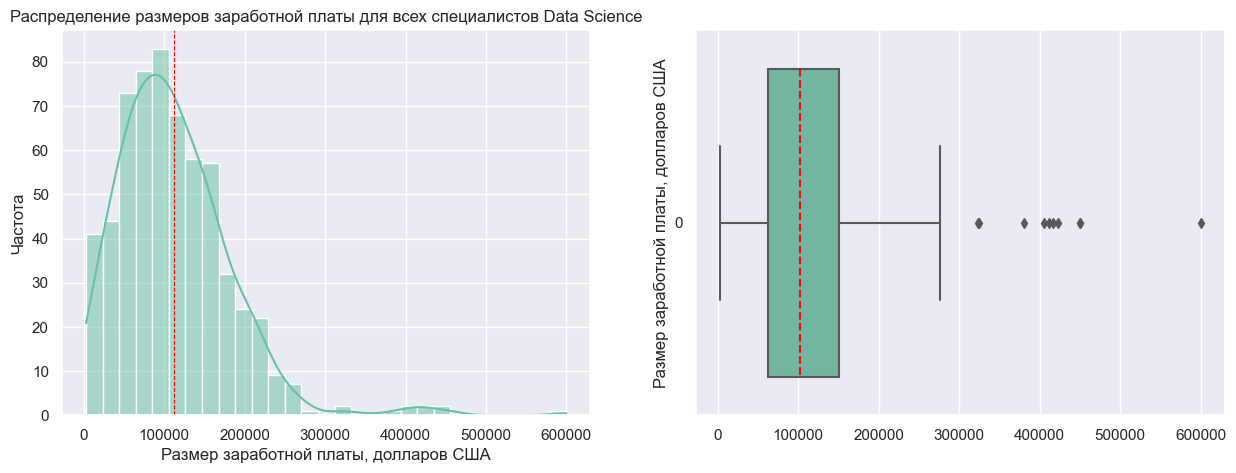

In [79]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(data['salary_in_usd'], kde=True, ax=axes[0])
axes[0].set(xlabel='Размер заработной платы, долларов США', ylabel='Частота')
axes[0].set_title('Распределение размеров заработной платы для всех специалистов Data Science')
axes[0].axvline(data['salary_in_usd'].mean(), color='red', linestyle='--', linewidth=0.8)

sns.boxplot(data['salary_in_usd'], ax=axes[1], orient='h', medianprops={"color": "red", "linestyle": '--'})
axes[1].set(ylabel='Размер заработной платы, долларов США')

plt.show()

In [80]:
data_agg = data['salary_in_usd'].describe().round(2).to_frame()
data_agg.columns = ['Размер заработных плат']
data_agg

,Размер заработных плат
count,607.00
mean,112297.87
std,70957.26
min,2859.00
25%,62726.00
50%,101570.00
75%,150000.00
max,600000.00


Распределение размеров заработных плат специалистов Data Science отлично от нормального, имеются выбросы.

### Визуализация данных: размер заработных плат в зависимости от года

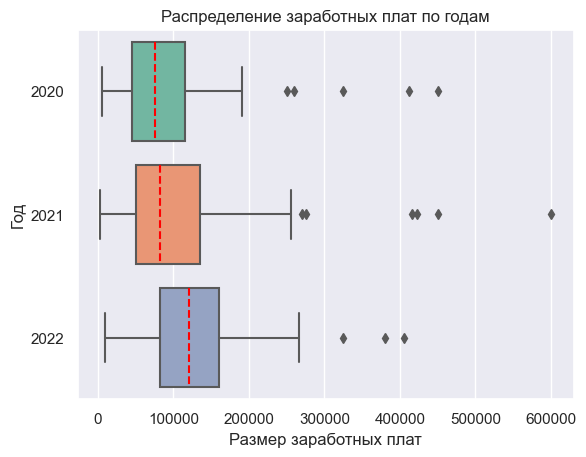

In [81]:
ax = sns.boxplot(data, x='salary_in_usd', y='work_year', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Размер заработных плат', ylabel='Год')
plt.title('Распределение заработных плат по годам')
plt.show()

In [82]:
data_agg = data.groupby('work_year')['salary_in_usd'].describe().round(2)
print('Заработные платы в зависимости от года')
data_agg

Заработные платы в зависимости от года


,count,mean,std,min,25%,50%,75%,max
work_year,,,,,,,,
2020,72.0,95813.00,82831.80,5707.0,45724.5,75544.0,115526.0,450000.0
2021,217.0,99853.79,80225.11,2859.0,50000.0,82528.0,135000.0,600000.0
2022,318.0,124522.01,58183.65,10000.0,81666.0,120000.0,160000.0,405000.0


Визуально можем наблюдать увеличение заработных плат (среднего значения и медианы) 2021 года относительно 2020 и, особенно, 2022 года по сравнению с 2021 и, ещё значительнее, с 2020 годом. Предварительные выводы необходимо подтвердить статистическим тестированием.

### Какие факторы влияют на зарплату?

### 1. Опыт работы

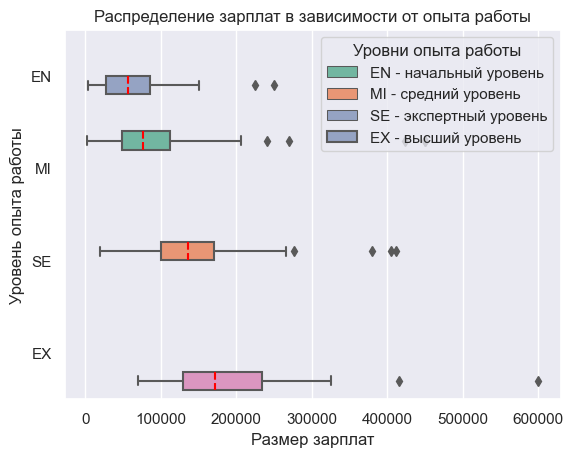

In [83]:
ax = sns.boxplot(data, x='salary_in_usd', y='experience_level', hue='experience_level', order=["EN", "MI", "SE", "EX"], orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Размер зарплат', ylabel='Уровень опыта работы')
plt.legend(title='Уровни опыта работы', loc = 'upper right', labels=["EN - начальный уровень", "MI - средний уровень", "SE - экспертный уровень", "EX - высший уровень"])
plt.title('Распределение зарплат в зависимости от опыта работы')
plt.show()

In [84]:
data_agg = data.groupby('experience_level')['salary_in_usd'].describe().round(2)
print('Зарплаты в зависимости от опыта работы')
data_agg

Зарплаты в зависимости от опыта работы


,count,mean,std,min,25%,50%,75%,max
experience_level,,,,,,,,
EN,88.0,61643.32,44395.54,4000.0,27505.0,56500.0,85425.75,250000.0
EX,26.0,199392.04,117071.26,69741.0,130006.5,171437.5,233750.00,600000.0
MI,213.0,87996.06,63901.06,2859.0,48000.0,76940.0,112000.00,450000.0
SE,280.0,138617.29,57691.98,18907.0,100000.0,135500.0,170000.00,412000.0


Исходя из визуализации данных, существует прямая зависимость размера зарплат от уровня опыта работы. Чтобы определить, является ли эта зависимость статистически значимой, необходимы статистические тесты.

### 2. Тип трудоустройства

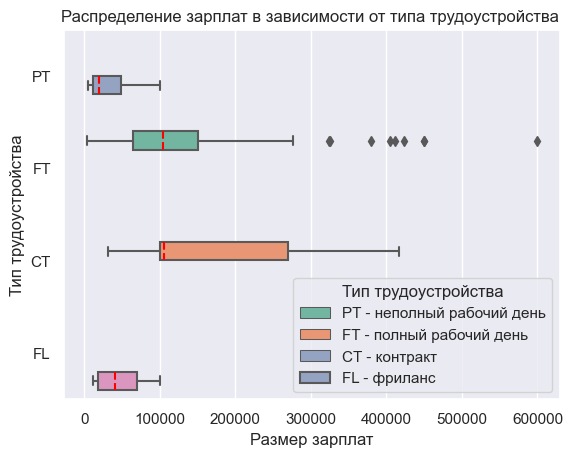

In [85]:
ax = sns.boxplot(data, x='salary_in_usd', y='employment_type', hue='employment_type', order=["PT", "FT", "CT", "FL"], orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Размер зарплат', ylabel='Тип трудоустройства')
plt.legend(title='Тип трудоустройства', loc = 'lower right', labels=["PT - неполный рабочий день", "FT - полный рабочий день", "CT - контракт", "FL - фриланс"])
plt.title('Распределение зарплат в зависимости от типа трудоустройства ')
plt.show()

In [86]:
data_agg = data.groupby('employment_type')['salary_in_usd'].describe().round(2)
print('Зарплаты в зависимости от трудоустройства')
data_agg

Зарплаты в зависимости от трудоустройства


,count,mean,std,min,25%,50%,75%,max
employment_type,,,,,,,,
CT,5.0,184575.00,156250.89,31875.0,100000.00,105000.0,270000.0,416000.0
FL,4.0,48000.00,40529.82,12000.0,18000.00,40000.0,70000.0,100000.0
FT,588.0,113468.07,69476.47,2859.0,64962.25,104196.5,150000.0,600000.0
PT,10.0,33070.50,31472.91,5409.0,12000.00,18817.5,48370.0,100000.0


В данном случае на основании визуализации можно сделать вывод, что зарплаты для различных типов трудоустройства отличаются. Чтобы определить, являются ли эти различия статистически значимыми, в следующем разделе мы проведём статистические тесты.

### 3. Текущая специальность сотрудника

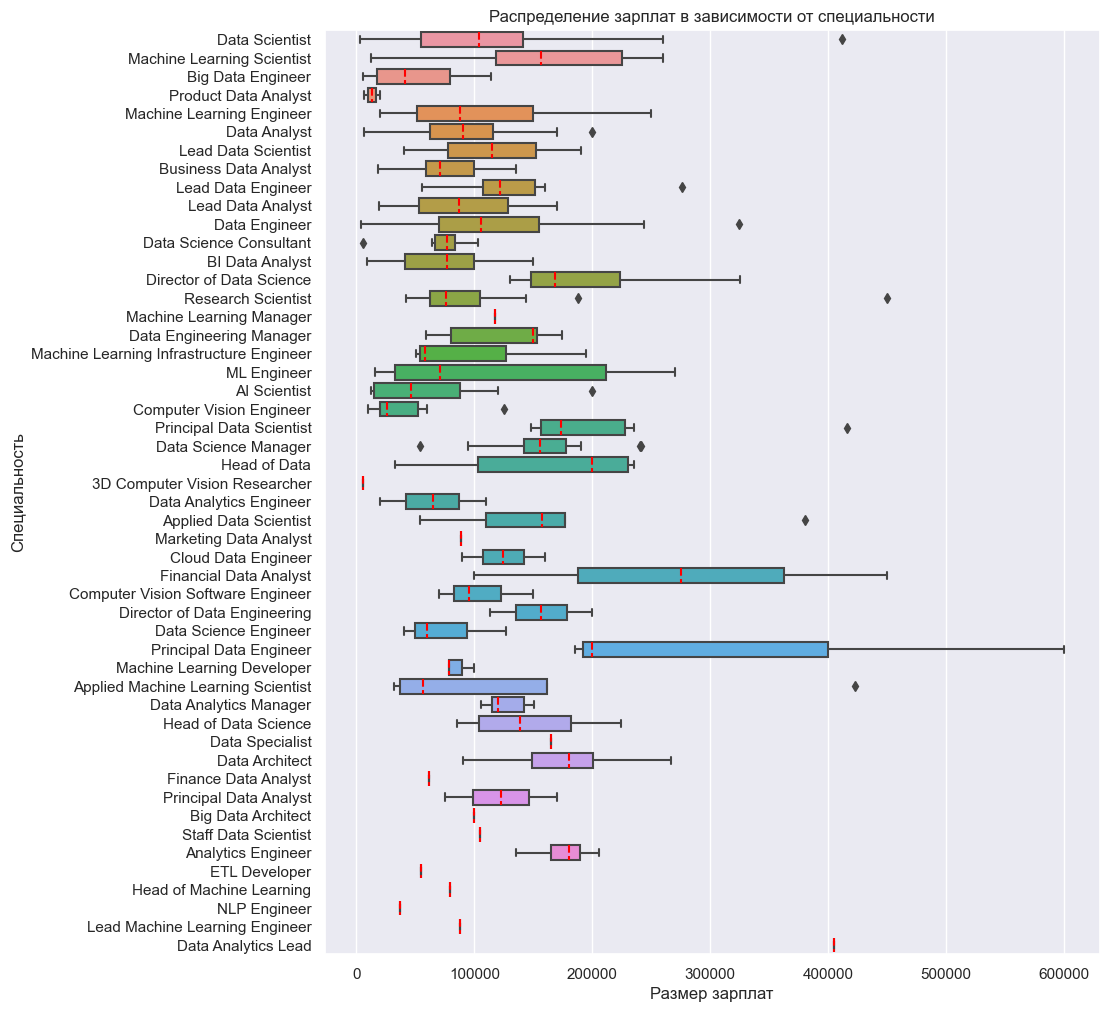

In [87]:
fig, ax = plt.subplots(figsize=(10, 12))
ax = sns.boxplot(data, x='salary_in_usd', y='job_title', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Размер зарплат', ylabel='Специальность')
plt.title('Распределение зарплат в зависимости от специальности')
plt.show()

In [88]:
data_agg = data.groupby('job_title')['salary_in_usd'].describe().round(2)
print('Зарплаты в зависимости от специальности')
data_agg

Зарплаты в зависимости от специальности


,count,mean,std,min,25%,50%,75%,max
job_title,,,,,,,,
3D Computer Vision Researcher,1.0,5409.00,NaN,5409.0,5409.00,5409.0,5409.00,5409.0
AI Scientist,7.0,66135.57,70152.16,12000.0,15026.50,45896.0,87500.00,200000.0
Analytics Engineer,4.0,175000.00,29508.08,135000.0,165000.00,179850.0,189850.00,205300.0
Applied Data Scientist,5.0,175655.00,123647.19,54238.0,110037.00,157000.0,177000.00,380000.0
Applied Machine Learning Scientist,4.0,142068.75,188246.70,31875.0,36768.75,56700.0,162000.00,423000.0
BI Data Analyst,6.0,74755.17,50989.56,9272.0,40944.25,76500.0,99500.00,150000.0
Big Data Architect,1.0,99703.00,NaN,99703.0,99703.00,99703.0,99703.00,99703.0
Big Data Engineer,8.0,51974.00,42954.76,5882.0,17557.00,41305.5,79756.00,114047.0
Business Data Analyst,5.0,76691.20,43814.85,18442.0,59102.00,70912.0,100000.00,135000.0


На основании визуализации можно сделать вывод, что зарплаты для различных специальностей DS отличаются. Однако в связи с большим количеством категорий в данном признаке, проводить статистические тесты на подтверждение влияния специальности на размер зарплаты не целесообразно, по крайней мере, без преобразования этого признака, либо проектирования на его основе нового признака.

### 4. Страна проживания сотрудника

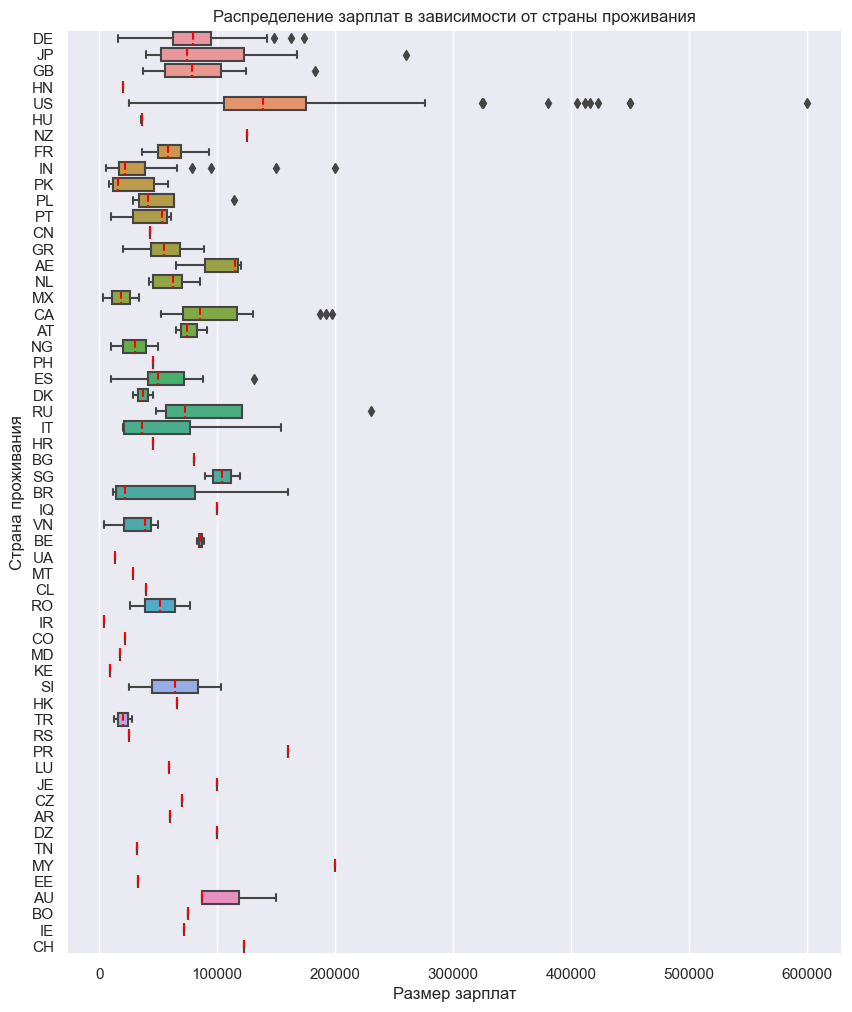

In [89]:
fig, ax = plt.subplots(figsize=(10, 12))
ax = sns.boxplot(data, x='salary_in_usd', y='employee_residence', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Размер зарплат', ylabel='Страна проживания')
plt.title('Распределение зарплат в зависимости от страны проживания')
plt.show()

In [90]:
data_agg = data.groupby('employee_residence')['salary_in_usd'].describe().round(2)
print('Зарплаты в зависимости от страны проживания')
data_agg

Зарплаты в зависимости от страны проживания


,count,mean,std,min,25%,50%,75%,max
employee_residence,,,,,,,,
AE,3.0,100000.00,30413.81,65000.0,90000.00,115000.0,117500.00,120000.0
AR,1.0,60000.00,NaN,60000.0,60000.00,60000.0,60000.00,60000.0
AT,3.0,76738.67,13386.02,64849.0,69489.50,74130.0,82683.50,91237.0
AU,3.0,108042.67,36337.91,86703.0,87064.00,87425.0,118712.50,150000.0
BE,2.0,85699.00,4179.00,82744.0,84221.50,85699.0,87176.50,88654.0
BG,1.0,80000.00,NaN,80000.0,80000.00,80000.0,80000.00,80000.0
BO,1.0,75000.00,NaN,75000.0,75000.00,75000.0,75000.00,75000.0
BR,6.0,54634.67,61537.35,12000.0,14402.50,21453.5,81000.00,160000.0
CA,29.0,97085.31,39767.44,52000.0,70912.00,85000.0,117104.00,196979.0


На основании визуализации можно сделать вывод, что зарплаты для жителей разных стран отличаются. В связи с тем, что признак "employee_residence" содержит слишком большое количество категорий, введем новый признак "region_residence", в котором сгруппируем страны по континентам в соответствии с географическим расположением.

In [91]:
# Добавим новый признак
# Распределим встречающиеся в данных страны по континентам
def get_update_residence(x):
    Australia = ['AU', 'NZ']
    Asia = ['AE', 'CN', 'IL', 'IQ', 'IR', 'JP', 'MY', 'PK', 'RU', 'SG', 'TR', 'VN']
    America = ['AS', 'BR', 'CA', 'CL', 'CO', 'HN', 'MX', 'US']
    Africa = ['DZ', 'KE', 'NG']
    Europe = ['AT', 'BE', 'CH', 'CZ', 'DE', 'DK', 'EE', 'ES', 'FR', 'GB', 'GR', 'HR', 'HU', 'IE', 'IT', 'LU', 'MD', 'MT', 'NL', 'PL', 'PT', 'RO', 'SI', ]
    
    if x in Australia:
        return 'Australia'
    elif x in Asia:
        return 'Asia'
    elif x in America:
        return 'America'
    elif x in Africa:
        return 'Africa'
    elif x in Europe:
        return 'Europe'
data['region_residence'] = data['employee_residence'].apply(get_update_residence)
print(data['region_residence'].nunique())
data.head()

5


,Unnamed: 0,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,region_residence
0,0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L,Europe
1,1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S,Asia
2,2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M,Europe
3,3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S,America
4,4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L,America


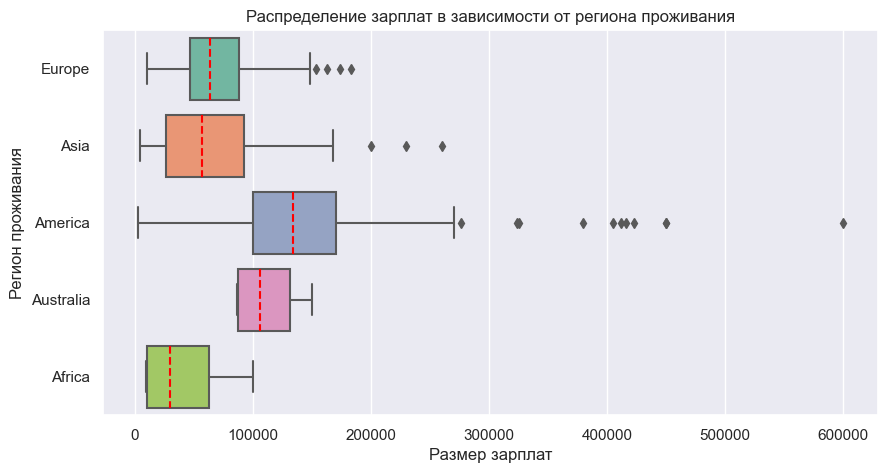

In [92]:
fig, ax = plt.subplots(figsize=(10, 5))
ax = sns.boxplot(data, x='salary_in_usd', y='region_residence', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Размер зарплат', ylabel='Регион проживания')
plt.title('Распределение зарплат в зависимости от региона проживания')
plt.show()

In [93]:
data_agg = data.groupby('region_residence')['salary_in_usd'].describe().round(2)
print('Зарплаты в зависимости от региона проживания')
data_agg

Зарплаты в зависимости от региона проживания


,count,mean,std,min,25%,50%,75%,max
region_residence,,,,,,,,
Africa,4.0,42318.00,42905.78,9272.0,9818.00,30000.0,62500.0,100000.0
America,372.0,141919.30,69631.52,2859.0,100000.00,133660.0,170000.0,600000.0
Asia,32.0,72528.59,64935.74,4000.0,26054.75,56388.5,91970.5,260000.0
Australia,4.0,112282.00,30857.47,86703.0,87244.50,106212.5,131250.0,150000.0
Europe,155.0,68737.11,32280.51,10000.0,46678.00,63831.0,87932.0,183228.0


Зарплаты жителей различных континентов отличаются. Необходимо подтвердить предварительный вывод статистическими тестами.

### 5. Объем работы, выполняемый удалено

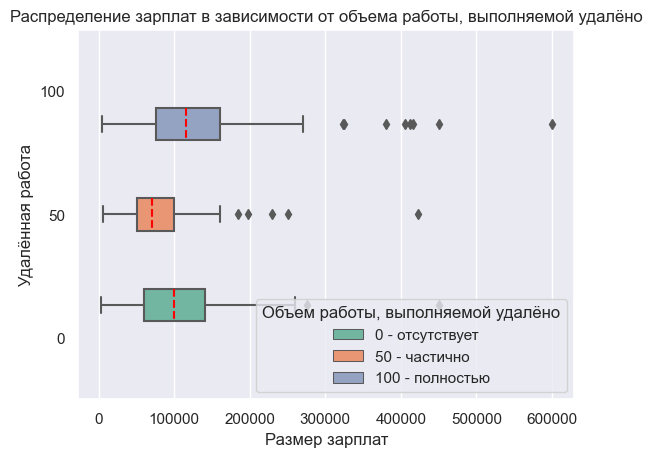

In [94]:
ax = sns.boxplot(data, x='salary_in_usd', y='remote_ratio', hue='remote_ratio', order=[100, 50, 0], orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Размер зарплат', ylabel='Удалённая работа')
plt.legend(title='Объем работы, выполняемой удалёно', loc = 'lower right', labels=["0 - отсутствует", "50 - частично", "100 - полностью"])
plt.title('Распределение зарплат в зависимости от объема работы, выполняемой удалёно')
plt.show()

In [95]:
data_agg = data.groupby('remote_ratio')['salary_in_usd'].describe().round(2)
print('Зарплаты в зависимости от объема работы, выполняемой удалено')
data_agg

Зарплаты в зависимости от объема работы, выполняемой удалено


,count,mean,std,min,25%,50%,75%,max
remote_ratio,,,,,,,,
0,127.0,106354.62,67724.54,2859.0,60000.0,99000.0,140400.0,450000.0
50,99.0,80823.03,57353.09,5409.0,50355.0,69999.0,99851.5,423000.0
100,381.0,122457.45,72710.84,4000.0,75774.0,115000.0,160000.0,600000.0


На первый взгляд размер зарплаты незначительно и не на прямую (нет закономерности, что чем больше/меньше доля удалёной работы, тем больще/меньше зарплата) зависит от количества работы, выполняемой удалёно. Для подтверждения этих выводов необходимо провести статистические тесты.

### 6. Страна расположения работодателя

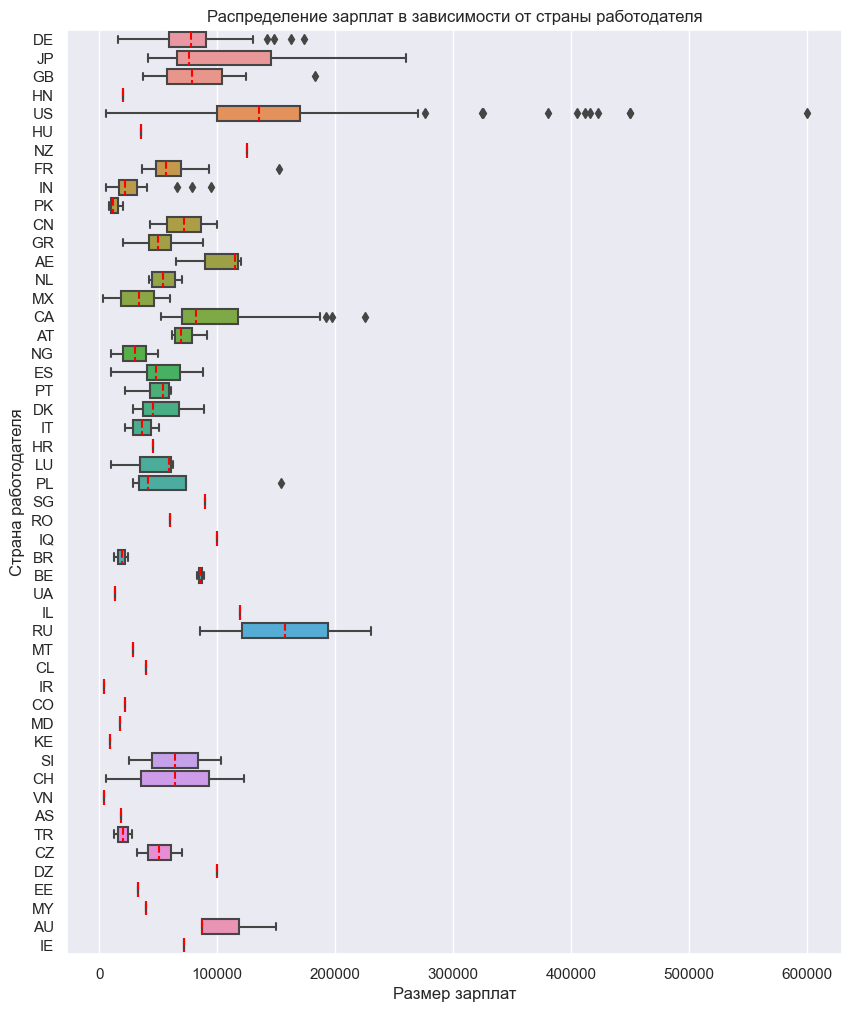

In [96]:
fig, ax = plt.subplots(figsize=(10, 12))
ax = sns.boxplot(data, x='salary_in_usd', y='company_location', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Размер зарплат', ylabel='Страна работодателя')
plt.title('Распределение зарплат в зависимости от страны работодателя')
plt.show()

In [97]:
data_agg = data.groupby('company_location')['salary_in_usd'].describe().round(2)
print('Зарплаты в зависимости от страны работодателя')
data_agg

Зарплаты в зависимости от страны работодателя


,count,mean,std,min,25%,50%,75%,max
company_location,,,,,,,,
AE,3.0,100000.00,30413.81,65000.0,90000.00,115000.0,117500.00,120000.0
AS,1.0,18053.00,NaN,18053.0,18053.00,18053.0,18053.00,18053.0
AT,4.0,72920.75,13332.78,61467.0,64003.50,69489.5,78406.75,91237.0
AU,3.0,108042.67,36337.91,86703.0,87064.00,87425.0,118712.50,150000.0
BE,2.0,85699.00,4179.00,82744.0,84221.50,85699.0,87176.50,88654.0
BR,3.0,18602.67,5555.76,12901.0,15904.00,18907.0,21453.50,24000.0
CA,30.0,99823.73,46329.10,52000.0,69730.00,81895.5,117916.25,225000.0
CH,2.0,64114.00,82352.48,5882.0,34998.00,64114.0,93230.00,122346.0
CL,1.0,40038.00,NaN,40038.0,40038.00,40038.0,40038.00,40038.0


На основании визуализации можно сделать вывод, что зарплаты, предлагаемые компаниями разных стран отличаются. В связи с тем, что признак "company_location" содержит слишком большое количество категорий, введем новый признак "region_location", в котором сгруппируем страны по континентам в соответствии с географическим расположением.

In [98]:
# Добавим новый признак
# Распределим встречающиеся в данных страны по континентам
def get_update_location(x):
    Australia = ['AU', 'NZ']
    Asia = ['AE', 'CN', 'IL', 'IQ', 'IR', 'JP', 'MY', 'PK', 'RU', 'SG', 'TR', 'VN']
    America = ['AS', 'BR', 'CA', 'CL', 'CO', 'HN', 'MX', 'US']
    Africa = ['DZ', 'KE', 'NG']
    Europe = ['AT', 'BE', 'CH', 'CZ', 'DE', 'DK', 'EE', 'ES', 'FR', 'GB', 'GR', 'HR', 'HU', 'IE', 'IT', 'LU', 'MD', 'MT', 'NL', 'PL', 'PT', 'RO', 'SI', ]
    
    if x in Australia:
        return 'Australia'
    elif x in Asia:
        return 'Asia'
    elif x in America:
        return 'America'
    elif x in Africa:
        return 'Africa'
    elif x in Europe:
        return 'Europe'
data['region_location'] = data['company_location'].apply(get_update_location)
print(data['region_location'].nunique())
data.head()

5


,Unnamed: 0,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,region_residence,region_location
0,0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L,Europe,Europe
1,1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S,Asia,Asia
2,2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M,Europe,Europe
3,3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S,America,America
4,4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L,America,America


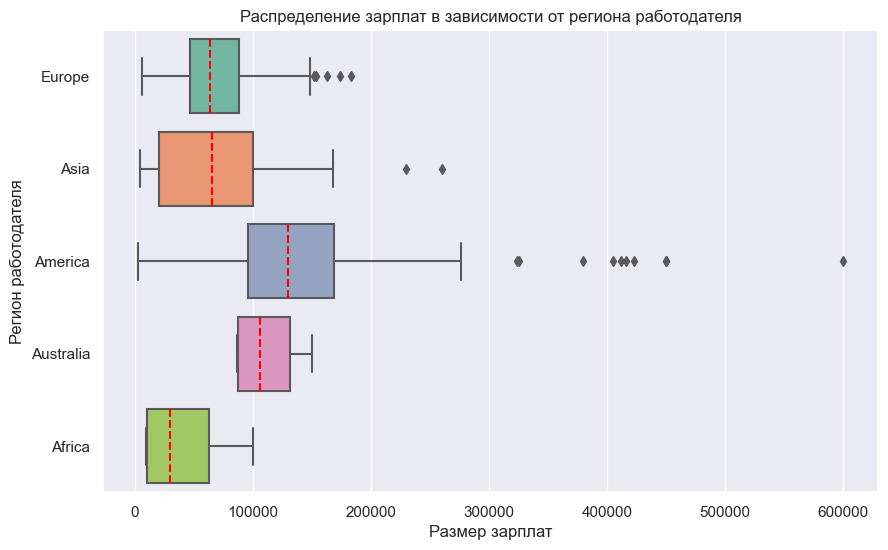

In [99]:
fig, ax = plt.subplots(figsize=(10, 6))
ax = sns.boxplot(data, x='salary_in_usd', y='region_location', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Размер зарплат', ylabel='Регион работодателя')
plt.title('Распределение зарплат в зависимости от региона работодателя')
plt.show()

In [100]:
data_agg = data.groupby('region_location')['salary_in_usd'].describe().round(2)
print('Зарплаты в зависимости от региона работодателя')
data_agg

Зарплаты в зависимости от региона работодателя


,count,mean,std,min,25%,50%,75%,max
region_location,,,,,,,,
Africa,4.0,42318.00,42905.78,9272.0,9818.0,30000.0,62500.0,100000.0
America,395.0,137687.20,70861.78,2859.0,95648.0,130000.0,168937.5,600000.0
Asia,25.0,75989.52,67175.57,4000.0,20171.0,65000.0,100000.0,260000.0
Australia,4.0,112282.00,30857.47,86703.0,87244.5,106212.5,131250.0,150000.0
Europe,154.0,68577.04,32808.18,5882.0,46637.5,63278.5,87932.0,183228.0


Размер зарплат различаются в разных локациях работодателей. Необходимо статистическое подтверждение данного предварительного вывода.

### 7. Количество сотрудников в компании-работодателе

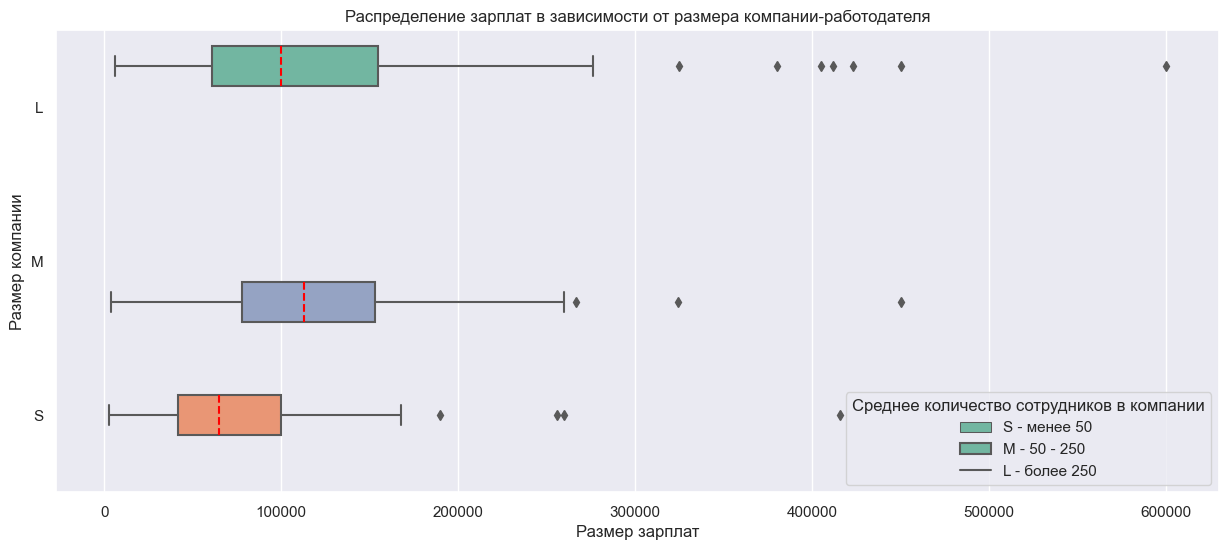

In [101]:
fig, ax = plt.subplots(figsize=(15, 6))
ax = sns.boxplot(data, x='salary_in_usd', y='company_size', hue='company_size', order=["L", "M", "S"], orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Размер зарплат', ylabel='Размер компании')
plt.legend(title='Среднее количество сотрудников в компании', loc='lower right', labels=["S - менее 50", "M - 50 - 250", "L - более 250"])
plt.title('Распределение зарплат в зависимости от размера компании-работодателя')
plt.show()

In [102]:
data_agg = data.groupby('company_size')['salary_in_usd'].describe().round(2)
print('Зарплаты в зависимости от размера компании-работодателя')
data_agg

Зарплаты в зависимости от размера компании-работодателя


,count,mean,std,min,25%,50%,75%,max
company_size,,,,,,,,
L,198.0,119242.99,86156.74,5882.0,61041.75,100000.0,154600.0,600000.0
M,326.0,116905.47,59287.69,4000.0,78131.50,113188.0,152875.0,450000.0
S,83.0,77632.67,63461.71,2859.0,41943.00,65000.0,100000.0,416000.0


На первый взгляд размер зарплаты незначительно и не на прямую зависит от размера компании-работодателя. Для подтверждения этих выводов необходимо провести статистические тесты.

### Как соотносятся зарплаты Data Scientist и Data Engineer в различных компаниях?

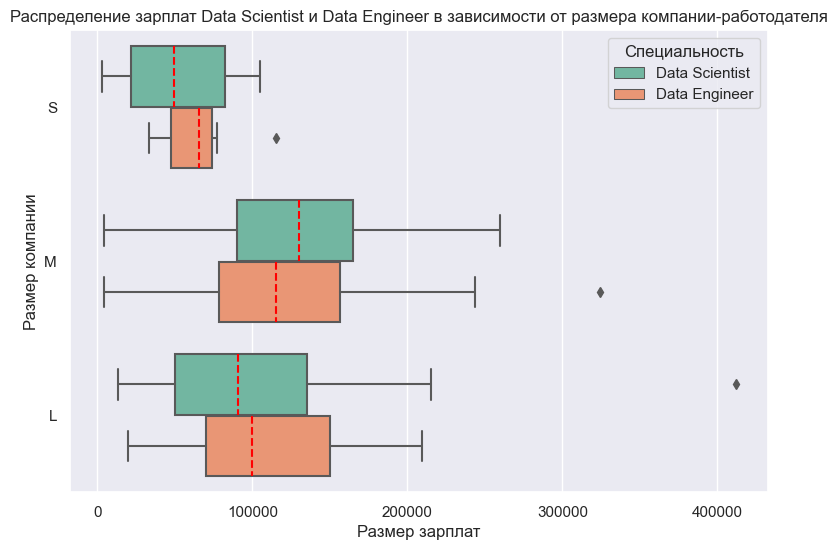

In [103]:
data1 = data[(data['job_title'] == 'Data Scientist') | (data['job_title'] == 'Data Engineer')]
fig, ax = plt.subplots(figsize=(9, 6))
ax = sns.boxplot(data1, x='salary_in_usd', y='company_size', hue='job_title', order=["S", "M", "L"], orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Размер зарплат', ylabel='Размер компании')
plt.legend(title='Специальность', loc='upper right')
plt.title('Распределение зарплат Data Scientist и Data Engineer в зависимости от размера компании-работодателя')
plt.show()

На основании визуализации полученных данных можно предварительно заключить, что соотношение зарплат Data Scientist и Data Engineer различно в компаниях разного размера: в больших и маленьких компаниях зарплата Data Engineer незначительно больше, чем у Data Scientist, в компаниях среднего размера наоборот, при большем уровне зарплат. Необходимо подтвердить статистическую значимость данных различий.

### Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?

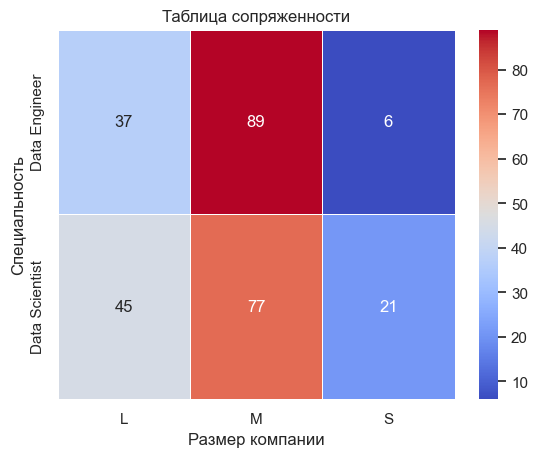

In [104]:
cross_tab = pd.crosstab(index=data1['job_title'], columns=data['company_size'])
ax = sns.heatmap(cross_tab, annot=True, linewidth=.5, fmt='.0f', cmap="coolwarm")
ax.set(xlabel='Размер компании', ylabel='Специальность')
plt.title('Таблица сопряженности')
plt.show()

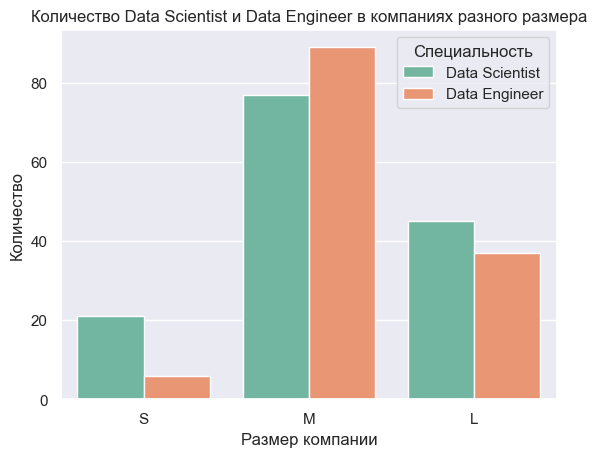

In [105]:
ax = sns.countplot(data=data1, x=data1['company_size'], hue='job_title', order=["S", "M", "L"])
ax.set(xlabel='Размер компании', ylabel='Количество')
plt.title('Количество Data Scientist и Data Engineer в компаниях разного размера')
plt.legend(title='Специальность', loc='upper right')
plt.show()

Согласно данным, больше всего специалистов интересующего нас профиля в компаниях среднего размера, на втором месте - большие компании и в маленьких меньше всего. Чтобы определить, являются ли эти различия статистически значимыми, в следующем разделе мы проведём статистические тесты.

## Статистический анализ данных



In [106]:
# функция для принятия решения о нормальности
def decision_normality(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Распределение отлично от нормального'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. Распределение является нормальным'.format(alpha))


# функция для принятия решения об отклонении нулевой гипотезы
def decision_hypothesis(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу в пользу альтернативной.'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))
  
# задаём уровень значимости
alpha = 0.05 
print("Уровень значимости alpha = {:.2f}".format(alpha))    

Уровень значимости alpha = 0.05


### Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): размер зарплат 2022 года ($μ_1$) статистически меньше либо равен размеру зарплат 2021 года ($μ_2$), который в свою очередь статистически меньше либо равен размеру зарплат 2020 года ($μ_3$).

$$ H_0 : μ_1 <= μ_2 <= μ_3$$

*Альтернативная гипотеза* ($H_1$): размер зарплат 2022 года ($μ_1$) статистически больше, чем размер зарплат 2021 года ($μ_2$), который в свою очередь статистически больше размера зарплат 2020 года ($μ_3$).

$$ H_1 : μ_1 > μ_2 > μ_3$$

**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально. Напомним гипотезы теста Шапиро-Уилка:

*Нулевая гипотеза* ($H_0$): распределение данные является нормальным.

*Альтернативная гипотеза* ($H_1$): распределение данных отлично от нормального.

In [107]:
# размер зарплат
salary_2022 = data.loc[data['work_year']==2022, 'salary_in_usd']
salary_2021 = data.loc[data['work_year']==2021, 'salary_in_usd']
salary_2020 = data.loc[data['work_year']==2020, 'salary_in_usd']

# проводим тест Шапиро-Уилка
print('Для 2022:')
result = stats.shapiro(salary_2022)
decision_normality(result[1])

print('Для 2021:')
result = stats.shapiro(salary_2021)
decision_normality(result[1])

print('Для 2020:')
result = stats.shapiro(salary_2020)
decision_normality(result[1])

Для 2022:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для 2021:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для 2020:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Размер зарплат? — Количественный.
* Сколько сравниваемых групп? — 3.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет.

Чтобы проверить нашу гипотезу, можно использовать критерий Краскела - Уоллиса для сравнения распределений на основе рангов.

**Проведём тест**

In [108]:
# проводим тест
_, p = stats.kruskal(salary_2022, salary_2021, salary_2020)
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**

Мы можем на основании изучаемых данных статистически подтвердить ежегодный рост зарплат у специалистов Data Scientist.

### Какие факторы влияют на зарплату у специалистов Data Scientist?

Рассмотрим поочередно влияние всех признаков из полученных данных:

### 1. Опыт работы


**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): размер зарплат начинающего специалиста ($μ_1$) статистически равен размеру зарплат специалиста со средним уровнем опыта ($μ_2$), который в свою очередь статистически равен размеру зарплат эксперта ($μ_3$) и специалиста высшего уровня опыта ($μ_4$).

$$ H_0 : μ_1 = μ_2 = μ_3 = μ_4$$

*Альтернативная гипотеза* ($H_1$): размер зарплат начинающего специалиста ($μ_1$) статистически не равен размеру зарплат специалиста со средним уровнем опыта ($μ_2$), который в свою очередь статистически не равен размеру зарплат эксперта ($μ_3$) и специалиста высшего уровня опыта ($μ_4$).

$$ H_0 : μ_1 != μ_2 != μ_3 != μ_4$$



**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально.

In [109]:
# размер зарплат
salary_EN = data.loc[data['experience_level']=='EN', 'salary_in_usd']
salary_MI = data.loc[data['experience_level']=='MI', 'salary_in_usd']
salary_SE = data.loc[data['experience_level']=='SE', 'salary_in_usd']
salary_EX = data.loc[data['experience_level']=='EX', 'salary_in_usd']

# проводим тест Шапиро-Уилка
print('Для EN:')
result = stats.shapiro(salary_EN)
decision_normality(result[1])

print('Для MI:')
result = stats.shapiro(salary_MI)
decision_normality(result[1])

print('Для SE:')
result = stats.shapiro(salary_SE)
decision_normality(result[1])

print('Для EX:')
result = stats.shapiro(salary_EX)
decision_normality(result[1])

Для EN:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для MI:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для SE:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для EX:
p-value = 0.001
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Размер зарплат»? — Количественный.
* Сколько сравниваемых групп? — 4.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет.

Для проверки нашей гипотезы можно использовать критерий Краскела - Уоллиса.

**Проведём тест**


In [110]:
# проводим тест
_, p = stats.kruskal(salary_EN, salary_MI, salary_SE, salary_EX)
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**

Уровень опыта работы сотрудника влияет на размер заработной платы.

### 2. Тип трудоустройства


**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): размер зарплат специалиста, трудоустроенного на неполный рабочий день ($μ_1$), статистически равен размеру зарплат специалиста, работающего полный рабочий день ($μ_2$), который в свою очередь статистически равен размеру зарплат специалиста по контракту ($μ_3$) и специалиста на фрилансе ($μ_4$).

$$ H_0 : μ_1 = μ_2 = μ_3 = μ_4$$

*Альтернативная гипотеза* ($H_1$):  размер зарплат специалиста, трудоустроенного на неполный рабочий день ($μ_1$), статистически не равен размеру зарплат специалиста, работающего полный рабочий день ($μ_2$), который в свою очередь статистически не равен размеру зарплат специалиста по контракту ($μ_3$) и специалиста на фрилансе ($μ_4$).

$$ H_0 : μ_1 != μ_2 != μ_3 != μ_4$$

In [111]:
# Проверка на нормальность
# размер зарплат
salary_PT = data.loc[data['employment_type']=='PT', 'salary_in_usd']
salary_FT = data.loc[data['employment_type']=='FT', 'salary_in_usd']
salary_CT = data.loc[data['employment_type']=='CT', 'salary_in_usd']
salary_FL = data.loc[data['employment_type']=='FL', 'salary_in_usd']

# проводим тест Шапиро-Уилка
print('Для PT:')
result = stats.shapiro(salary_PT)
decision_normality(result[1])

print('Для FT:')
result = stats.shapiro(salary_FT)
decision_normality(result[1])

print('Для CT:')
result = stats.shapiro(salary_CT)
decision_normality(result[1])

print('Для FL:')
result = stats.shapiro(salary_FL)
decision_normality(result[1])

Для PT:
p-value = 0.023
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для FT:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для CT:
p-value = 0.406
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для FL:
p-value = 0.507
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Размер зарплат»? — Количественный.
* Сколько сравниваемых групп? — 4.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет.

Для проверки нашей гипотезы можно использовать критерий Краскела - Уоллиса.

**Проведём тест**


In [112]:
# проводим тест
_, p = stats.kruskal(salary_PT, salary_FT, salary_CT, salary_FL)
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**

Тип трудоустройства сотрудника влияет на размер заработной платы.

### 3. Регион проживания


**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): размер зарплат специалиста, проживающего в Австралии ($μ_1$), статистически равен размеру зарплат специалиста из Азии ($μ_2$), который в свою очередь статистически равен размеру зарплат специалиста из Америки ($μ_3$) и специалиста из Африки ($μ_4$) и Европы ($μ_5$).

$$ H_0 : μ_1 = μ_2 = μ_3 = μ_4 = μ_5$$

*Альтернативная гипотеза* ($H_1$):  размер зарплат специалиста, проживающего в Австралии ($μ_1$), статистически не равен размеру зарплат специалиста из Азии ($μ_2$), который в свою очередь статистически не равен размеру зарплат специалиста из Америки ($μ_3$) и специалиста из Африки ($μ_4$) и Европы ($μ_5$).

$$ H_0 : μ_1 != μ_2 != μ_3 != μ_4 != μ_5$$

In [113]:
# Проверка на нормальность
# размер зарплат
salary_Au = data.loc[data['region_residence']=='Australia', 'salary_in_usd']
salary_As = data.loc[data['region_residence']=='Asia', 'salary_in_usd']
salary_Am = data.loc[data['region_residence']=='America', 'salary_in_usd']
salary_Af = data.loc[data['region_residence']=='Africa', 'salary_in_usd']
salary_Eu = data.loc[data['region_residence']=='Europe', 'salary_in_usd']

# проводим тест Шапиро-Уилка
print('Для Australia:')
result = stats.shapiro(salary_Au)
decision_normality(result[1])

print('Для Asia:')
result = stats.shapiro(salary_As)
decision_normality(result[1])

print('Для America:')
result = stats.shapiro(salary_Am)
decision_normality(result[1])

print('Для Africa:')
result = stats.shapiro(salary_Af)
decision_normality(result[1])

print('Для Europe:')
result = stats.shapiro(salary_Eu)
decision_normality(result[1])

Для Australia:
p-value = 0.284
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для Asia:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для America:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для Africa:
p-value = 0.268
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для Europe:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Размер зарплат»? — Количественный.
* Сколько сравниваемых групп? — 5.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет.

Для проверки нашей гипотезы можно использовать критерий Краскела - Уоллиса.

**Проведём тест**

In [114]:
# проводим тест
_, p = stats.kruskal(salary_Au, salary_As, salary_Am, salary_Af, salary_Eu)
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**

Регион проживания специалистов влияет на размер заработной платы.

### 4. Регион расположения работодателя



**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): размер зарплат у работодателя, расположенного в Австралии ($μ_1$), статистически равен размеру зарплат у работодателя из Азии ($μ_2$), который в свою очередь статистически равен размеру зарплат у работодателя из Америки ($μ_3$) и работодателя из Африки ($μ_4$) и Европы ($μ_5$).

$$ H_0 : μ_1 = μ_2 = μ_3 = μ_4 = μ_5$$

*Альтернативная гипотеза* ($H_1$):  размер зарплат у работодателя, расположенного в Австралии ($μ_1$), статистически не равен размеру зарплат у работодателя из Азии ($μ_2$), который в свою очередь статистически не равен размеру зарплат у работодателя из Америки ($μ_3$) и работодателя из Африки ($μ_4$) и Европы ($μ_5$).

$$ H_0 : μ_1 != μ_2 != μ_3 != μ_4 != μ_5$$

In [115]:
# Проверка на нормальность
# размер зарплат
salary_Au_l = data.loc[data['region_location']=='Australia', 'salary_in_usd']
salary_As_l = data.loc[data['region_location']=='Asia', 'salary_in_usd']
salary_Am_l = data.loc[data['region_location']=='America', 'salary_in_usd']
salary_Af_l = data.loc[data['region_location']=='Africa', 'salary_in_usd']
salary_Eu_l = data.loc[data['region_location']=='Europe', 'salary_in_usd']

# проводим тест Шапиро-Уилка
print('Для Australia:')
result = stats.shapiro(salary_Au_l)
decision_normality(result[1])

print('Для Asia:')
result = stats.shapiro(salary_As_l)
decision_normality(result[1])

print('Для America:')
result = stats.shapiro(salary_Am_l)
decision_normality(result[1])

print('Для Africa:')
result = stats.shapiro(salary_Af_l)
decision_normality(result[1])

print('Для Europe:')
result = stats.shapiro(salary_Eu_l)
decision_normality(result[1])

Для Australia:
p-value = 0.284
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для Asia:
p-value = 0.005
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для America:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для Africa:
p-value = 0.268
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для Europe:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Размер зарплат»? — Количественный.
* Сколько сравниваемых групп? — 5.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет.

Для проверки нашей гипотезы можно использовать критерий Краскела - Уоллиса.

**Проведём тест**

In [116]:
# проводим тест
_, p = stats.kruskal(salary_Au_l, salary_As_l, salary_Am_l, salary_Af_l, salary_Eu_l)
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**

Регион локализации работодателя влияет на уровень зарплат.

### 5. Объем работы, выполняемой удалёно


**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): размер зарплат для специалистов, выполняющих всю работу в офисе ($μ_1$), статистически равен размеру зарплат специалистов частично работающих удалено ($μ_2$), который в свою очередь статистически равен размеру зарплат специалистов работающих удалено ($μ_3$).

$$ H_0 : μ_1 = μ_2 = μ_3$$

*Альтернативная гипотеза* ($H_1$):  размер зарплат для специалистов, выполняющих всю работу в офисе ($μ_1$), статистически не равен размеру зарплат специалистов частично работающих удалено ($μ_2$), который в свою очередь статистически не равен размеру зарплат специалистов работающих удалено ($μ_3$).

$$ H_0 : μ_1 != μ_2 != μ_3$$

In [117]:
# Проверка на нормальность
# размер зарплат
salary_0 = data.loc[data['remote_ratio']==0, 'salary_in_usd']
salary_50 = data.loc[data['remote_ratio']==50, 'salary_in_usd']
salary_100 = data.loc[data['remote_ratio']==100, 'salary_in_usd']

# проводим тест Шапиро-Уилка
print('Для офиса:')
result = stats.shapiro(salary_0)
decision_normality(result[1])

print('Для частично удаленной работы:')
result = stats.shapiro(salary_50)
decision_normality(result[1])

print('Для удаленной работы:')
result = stats.shapiro(salary_100)
decision_normality(result[1])

Для офиса:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для частично удаленной работы:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для удаленной работы:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Размер зарплат»? — Количественный.
* Сколько сравниваемых групп? — 3.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет.

Для проверки нашей гипотезы можно использовать критерий Краскела - Уоллиса.

**Проведём тест**

In [118]:
# проводим тест
_, p = stats.kruskal(salary_0, salary_50, salary_100)
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**

Объем работы, выполняемой удалено влияет на уровень зарплат.

### 6. Количество сотрудников в компании


**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): размер зарплат для специалистов, работающих в маленькой компании ($μ_1$), статистически равен размеру зарплат специалистов средней компании ($μ_2$), который в свою очередь статистически равен размеру зарплат специалистов крупных компаний ($μ_3$).

$$ H_0 : μ_1 = μ_2 = μ_3$$

*Альтернативная гипотеза* ($H_1$):  размер зарплат для специалистов, работающих в маленькой компании ($μ_1$), статистически не равен размеру зарплат специалистов средней компании ($μ_2$), который в свою очередь статистически не равен размеру зарплат специалистов крупных компаний ($μ_3$).

$$ H_0 : μ_1 != μ_2 != μ_3$$

In [119]:
# Проверка на нормальность
# размер зарплат
salary_S = data.loc[data['company_size']=='S', 'salary_in_usd']
salary_M = data.loc[data['company_size']=='M', 'salary_in_usd']
salary_L = data.loc[data['company_size']=='L', 'salary_in_usd']

# проводим тест Шапиро-Уилка
print('Для мелких компаний:')
result = stats.shapiro(salary_S)
decision_normality(result[1])

print('Для средних компаний:')
result = stats.shapiro(salary_M)
decision_normality(result[1])

print('Для крупных компаний:')
result = stats.shapiro(salary_L)
decision_normality(result[1])

Для мелких компаний:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для средних компаний:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для крупных компаний:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Размер зарплат»? — Количественный.
* Сколько сравниваемых групп? — 3.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет.

Для проверки нашей гипотезы можно использовать критерий Краскела - Уоллиса.

**Проведём тест**

In [120]:
# проводим тест
_, p = stats.kruskal(salary_S, salary_M, salary_L)
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**

Размер компании влияет на уровень зарплат.

### Как соотносятся зарплаты Data Scientist и Data Engineer в различных компаниях?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): размер зарплат Data Scientist и Data Engineer равны между собой и одинаковы в компаниях всех размеров.

$$ H_0 : μ_1 = μ_2 = μ_3 = μ_4 = μ_5 = μ_6$$

*Альтернативная гипотеза* ($H_1$): размер зарплат Data Scientist и Data Engineer отличаются между собой и в компаниях разных размеров.

$$ H_0 : μ_1 != μ_2 != μ_3 != μ_4 != μ_5 != μ_6$$

In [121]:
# Проверка на нормальность
# размер зарплат
salary_S_DS = data1.salary_in_usd[(data1['company_size']=='S') & (data1['job_title']=='Data Scientist')]
salary_M_DS = data1.salary_in_usd[(data1['company_size']=='M') & (data1['job_title']=='Data Scientist')]
salary_L_DS = data1.salary_in_usd[(data1['company_size']=='L') & (data1['job_title']=='Data Scientist')]
salary_S_DE = data1.salary_in_usd[(data1['company_size']=='S') & (data1['job_title']=='Data Engineer')]
salary_M_DE = data1.salary_in_usd[(data1['company_size']=='M') & (data1['job_title']=='Data Engineer')]
salary_L_DE = data1.salary_in_usd[(data1['company_size']=='L') & (data1['job_title']=='Data Engineer')]

# проводим тест Шапиро-Уилка
print('Для DS мелких компаний:')
result = stats.shapiro(salary_S_DS)
decision_normality(result[1])

print('Для DS средних компаний:')
result = stats.shapiro(salary_M_DS)
decision_normality(result[1])

print('Для DS крупных компаний:')
result = stats.shapiro(salary_L_DS)
decision_normality(result[1])

print('Для DE мелких компаний:')
result = stats.shapiro(salary_S_DE)
decision_normality(result[1])

print('Для DE средних компаний:')
result = stats.shapiro(salary_M_DE)
decision_normality(result[1])

print('Для DE крупных компаний:')
result = stats.shapiro(salary_L_DE)
decision_normality(result[1])

Для DS мелких компаний:
p-value = 0.189
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для DS средних компаний:
p-value = 0.639
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для DS крупных компаний:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для DE мелких компаний:
p-value = 0.606
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для DE средних компаний:
p-value = 0.104
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Для DE крупных компаний:
p-value = 0.052
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Размер зарплат»? — Количественный.
* Сколько сравниваемых групп? — 6.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет.

Для проверки нашей гипотезы можно использовать критерий Краскела - Уоллиса.

**Проведём тест**

In [122]:
# проводим тест
_, p = stats.kruskal(salary_S_DS, salary_M_DS, salary_L_DS, salary_S_DE, salary_M_DE, salary_L_DE)
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**

Уровень зарплат Data Scientist и Data Engineer отличается между собой и отличается в компаниях разного размера.

### Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза*: между размером компаний и наличием должностей Data Scientist и Data Engineer нет взаимосвязи (признаки независимы).

*Альтернативная гипотеза*: между размером компаний и наличием должностей Data Scientist и Data Engineer есть взаимосвязь (признаки зависимы).


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Специальность» ('job_title')? — Категориальный.
* Сколько сравниваемых групп? — Две.
* Проверяется независимость групп? — Да.

Для проверки нашей гипотезы можно использовать критерий ${\chi}^2$ (хи-квадрат).

**Проведём тест**

In [123]:
# составляем таблицу сопряжённости
cross_table = pd.crosstab(data1['job_title'], data1['company_size'])

cross_table

company_size,L,M,S
job_title,,,
Data Engineer,37,89,6
Data Scientist,45,77,21


In [124]:
# проводим тест
_, p, _, _ = stats.chi2_contingency(cross_table)
decision_hypothesis(p)

p-value = 0.008
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**

Существует статистически значимая взаимосвязь между размером компаний и наличием должностей Data Scientist и Data Engineer.

### Дополнительные исследования

### 1. Средняя зарплата Data Scientist в 2022 году составила 100 тысяч долларов?


**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): Средняя зарплата Data Scientist в 2022 году составила менее 100 тысяч долларов.

$$ H_0 : μ <= 100000$$

*Альтернативная гипотеза* ($H_1$):  Средняя зарплата Data Scientist в 2022 году больше 100 тысяч долларов.

$$ H_0 : μ > 100000$$


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Размер зарплат»? — Количественный.
* Сколько сравниваемых групп? — 1.
* Признак распределён по нормальному закону? — Да.

Для проверки нашей гипотезы можно использовать одновыборочный t-критерий.

**Проведём тест**

In [125]:
# Проверка на нормальность
# размер зарплат
data2 = data1.salary_in_usd[(data1['work_year']==2022) & (data1['job_title']=='Data Scientist')]

# проводим тест Шапиро-Уилка
print('Для DS в 2022:')
result = stats.shapiro(data2)
decision_normality(result[1])

Для DS в 2022:
p-value = 0.327
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным


In [126]:
# проводим тест
_, p = stats.ttest_1samp(data2, popmean=100000, alternative='greater')

print('p-value = {:.3f}'.format(p))

# интерпретируем результат
if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу.'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу.


**Вывод**

Статистически доказали, что средняя зарплата Data Scientist в 2022 году была больше 100 тыс. долларов.

### 2. Сравнить средние зарплат Data Scientist и Data Engineer в 20202 году.


**Сформулируем нулевую и альтернативные гипотезы**


*Нулевая гипотеза* ($H_0$): Средняя зарплата Data Scientist в 2020 году ($μ_1$) равна средней зарплате Data Engineer в том же году ($μ_2$).

$$ H_0 : μ_1 = μ_2$$

*Альтернативная гипотеза* ($H_1$):  Средняя зарплата Data Scientist в 2020 году ($μ_1$) не равна средней зарплате Data Engineer в том же году ($μ_2$).

$$ H_0 : μ_1 ! = μ_2$$


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Размер зарплат»? — Количественный.
* Сколько сравниваемых групп? — 2.
* Признак распределён по нормальному закону? — Нет.

Для проверки нашей гипотезы можно использовать одновыборочный U-критерий Манна-Уитни.

**Проведём тест**

In [127]:
# Проверка на нормальность
# размер зарплат
data_DS_20 = data1.salary_in_usd[(data1['work_year']==2020) & (data1['job_title']=='Data Scientist')]
data_DE_20 = data1.salary_in_usd[(data1['work_year']==2020) & (data1['job_title']=='Data Engineer')]

# проводим тест Шапиро-Уилка
print('Для DS в 2020:')
result = stats.shapiro(data_DS_20)
decision_normality(result[1])

print('Для DE в 2020:')
result = stats.shapiro(data_DE_20)
decision_normality(result[1])

Для DS в 2020:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для DE в 2020:
p-value = 0.341
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным


In [128]:
# проводим тест
_, p = stats.mannwhitneyu(data_DS_20, data_DE_20)

print('p-value = {:.3f}'.format(p))

# интерпретируем результат
if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу.'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))


p-value = 0.427
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


**Вывод**
У нас нет оснований утверждать, что средние зарплат Data Scientist и Data Engineer в 20202 году отличались.

## Итоговые результаты исследования

*   Мы можем на основании изучаемых данных статистически подтвердить ежегодный рост зарплат у специалистов Data Scientist.
*   На зарплату специалистов Data Scientist влияют следующие факторы: опыт работы, тип трудоустройства, регион проживания сотрудника и расположения компании, количество работы, выполняемой удалёно и размер компании.
*   Зарплаты Data Scientist и Data Engineer отличаются друг от друга и различны в компаниях разных размеров.
*   Существует статистически значимая взаимосвязь между размером компаний и наличием должностей Data Scientist и Data Engineer.